In [289]:
from abc import ABC, abstractmethod
import pathlib
import pandas as pd
import seaborn as sns
import lxml.html
from bs4 import BeautifulSoup
import timeit

In [230]:
class Comparison(ABC):

    examples = ["asha_bhosle", "html5test", "nba", "python"]

    def __init__(self):
        self.html = {}
        for example in self.examples:
            self.html[example] = (
                pathlib.Path("testdata") / f"{example}.html"
            ).read_text()

    def pre_parse(self):
        # Pre-parse the HTML to allow us to benchmark individual selections
        self.root = {}
        for name, html in self.html.items():
            self.root[name] = self.load_dom(name)


In [294]:
class Lxml(Comparison):
    def load_dom(self, example):
        return lxml.html.fromstring(self.html[example])

    def links_natural(self, example):
        return self.root[example].xpath("//a/@href")

    def links_css(self, example):
        return self.root[example].cssselect("a[href]")

    def count_elements(self, example):
        elements = []
        def count(element):
            elements.append(element.tag)
            for child in element.getchildren():
                count(child)
        count(self.root[example])
        return elements
        # return list(self.root[example].iter())

    def extract_text(self, example):
        return self.root[example].text_content()

    def __repr__(self):
        return "lxml.html"

In [296]:
class BSoup(Comparison):
    def __init__(self, parser):
        super().__init__()
        self.parser = parser

    def load_dom(self, example):
        return BeautifulSoup(self.html[example], self.parser)

    def links_natural(self, example):
        return self.root[example].find_all("a", href=True)

    def links_css(self, example):
        return self.root[example].select("a[href]")

    def count_elements(self, example):
        elements = []
        def count(element):
            elements.append(element.name)
            for child in getattr(element, "children", []):
                count(child)
        count(self.root[example])
        return elements
        #return list(self.root[example].recursiveChildGenerator())

    def extract_text(self, example):
        return self.root[example].get_text()

    def __repr__(self):
        return f"BeautifulSoup[{self.parser}]"

In [285]:
def run_all_benchmarks():
    methods = [
        #("load_dom", 5),
        #("links_natural", 100),
        #("links_css", 100),
        ("count_elements", 10),
        #("extract_text", 100),
    ]
    implementations = [
        Lxml(), BSoup("html.parser"), BSoup("html5lib"), BSoup("lxml")
    ]
    runs = []
    for impl in implementations:
        impl.pre_parse()
        for example in impl.examples:
            for method, count in methods:
                time = timeit.timeit("method(example)",
                    globals={"method": getattr(impl, method), "example": example},
                    number=count)
                results = len(getattr(impl, method)(example))
                runs.append({"implementation": str(impl),
                             "example": example,
                             "method": method,
                             "average_time": time / count,
                             "count": count,
                             "results": results})
    return pd.DataFrame(runs)


In [286]:
df = run_all_benchmarks()

In [283]:
def show_results(df, method, examples=None):
    """
    Show relative times and overall graph for benchmark.
    """
    sns.set_theme(style="white")
    filtered = df[df.method == method]
    if examples:
        filtered = filtered[(df.example.isin(examples))]
    ax = sns.barplot(filtered, x="example", y="average_time", hue="implementation")
    ax.set_ylabel("Avg. Time (s)")
    ax.set_xlabel("Example HTML")
    ax.set_title(f"{method} (N={filtered['count'].iloc[0]})")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    means = filtered.groupby("implementation").mean("average_time")
    means /= means.loc["lxml.html"]
    print(means)

    comparison = filtered[["implementation", "example", "results"]]
    print(comparison)

                            average_time  count  results
implementation                                          
BeautifulSoup[html.parser]      6.467704    1.0      1.0
BeautifulSoup[html5lib]         6.484449    1.0      1.0
BeautifulSoup[lxml]             6.492298    1.0      1.0
lxml.html                       1.000000    1.0      1.0
                implementation  results
1                    lxml.html     2511
16                   lxml.html    17229
21  BeautifulSoup[html.parser]     2511
36  BeautifulSoup[html.parser]    17229
41     BeautifulSoup[html5lib]     2511
56     BeautifulSoup[html5lib]    17229
61         BeautifulSoup[lxml]     2511
76         BeautifulSoup[lxml]    17229


/var/folders/5g/gtr086hd3q5gx90mgfzhrlhr0000gp/T/ipykernel_77911/4105738184.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(df.example.isin(examples))]


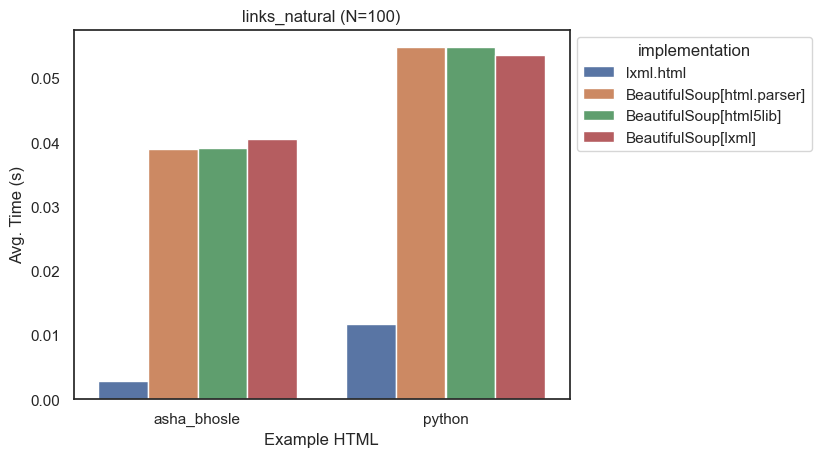

In [279]:
show_results(df, "links_natural", ["asha_bhosle", "python"])

                            average_time  count  results
implementation                                          
BeautifulSoup[html.parser]     12.102981    1.0      1.0
BeautifulSoup[html5lib]        13.504942    1.0      1.0
BeautifulSoup[lxml]            12.145327    1.0      1.0
lxml.html                       1.000000    1.0      1.0
                implementation  results
2                    lxml.html     2511
17                   lxml.html    17229
22  BeautifulSoup[html.parser]     2511
37  BeautifulSoup[html.parser]    17229
42     BeautifulSoup[html5lib]     2511
57     BeautifulSoup[html5lib]    17229
62         BeautifulSoup[lxml]     2511
77         BeautifulSoup[lxml]    17229


/var/folders/5g/gtr086hd3q5gx90mgfzhrlhr0000gp/T/ipykernel_77911/4105738184.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(df.example.isin(examples))]


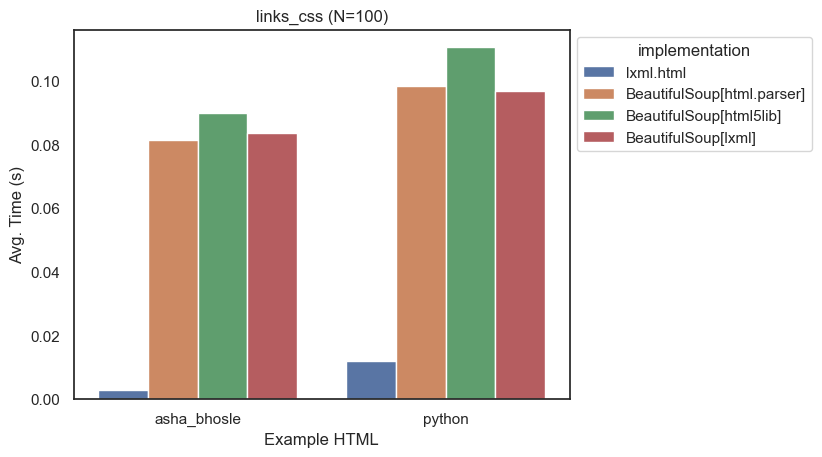

In [281]:
show_results(df, "links_css", ["asha_bhosle", "python"])

                            average_time  count   results
implementation                                           
BeautifulSoup[html.parser]      3.656389    1.0  2.530381
BeautifulSoup[html5lib]         3.615163    1.0  2.530667
BeautifulSoup[lxml]             3.445608    1.0  2.530340
lxml.html                       1.000000    1.0  1.000000
                implementation      example  results
0                    lxml.html  asha_bhosle    38458
3                    lxml.html       python    34944
4   BeautifulSoup[html.parser]  asha_bhosle    97786
7   BeautifulSoup[html.parser]       python    87949
8      BeautifulSoup[html5lib]  asha_bhosle    97783
11     BeautifulSoup[html5lib]       python    87973
12         BeautifulSoup[lxml]  asha_bhosle    97785
15         BeautifulSoup[lxml]       python    87947


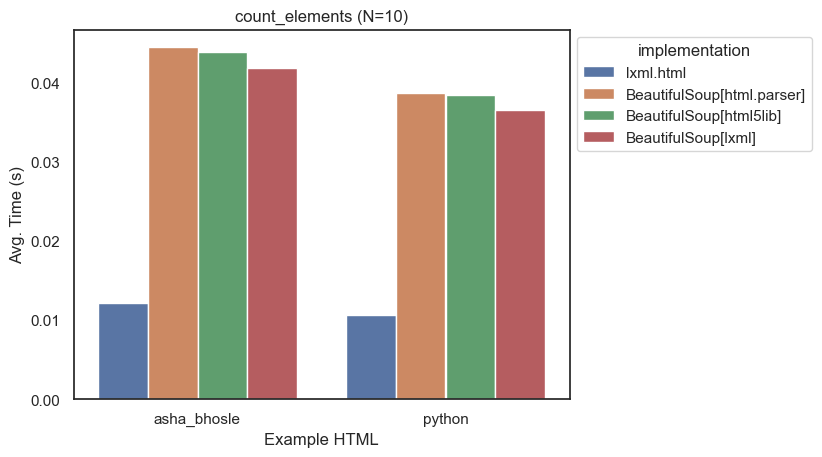

In [287]:
show_results(df, "count_elements", ["asha_bhosle", "python"])

In [297]:
# node comparison

lx = Lxml()
lx.pre_parse()
bsoup = BSoup("html.parser")
bsoup.pre_parse()

lxml_elems = lx.count_elements("html5test") 
bsoup_elems = bsoup.count_elements("html5test")

print(len(lxml_elems), len(bsoup_elems))

for elem in lx.count_elements("html5test"):
    print(elem)
for elem in bsoup.count_elements("html5test"):
    print(elem)


114 267
html
head
title
meta
meta
meta
meta
meta
link
script
script
script
script
meta
link
link
link
link
link
link
link
link
link
link
link
link
link
meta
meta
meta
meta
meta
meta
meta
meta
meta
link
<cyfunction Comment at 0x11c3953c0>
body
div
div
div
h1
span
strong
em
div
ul
li
a
li
a
li
a
ul
li
a
li
a
li
a
div
noscript
h2
div
div
div
div
div
div
div
<cyfunction Comment at 0x11c3953c0>
div
<cyfunction Comment at 0x11c3953c0>
div
div
h2
div
span
p
p
p
p
h3
p
div
a
span
a
span
a
span
a
span
div
<cyfunction Comment at 0x11c3953c0>
div
<cyfunction Comment at 0x11c3953c0>
div
div
div
p
br
br
a
abbr
a
div
a
b
br
br
div
script
[document]
None
None
html
None
head
None
title
None
None
meta
None
meta
None
meta
None
meta
None
meta
None
link
None
script
None
script
None
script
None
script
None
None
meta
None
link
None
link
None
link
None
link
None
link
None
link
None
link
None
link
None
link
None
link
None
link
None
link
None
link
None
meta
None
meta
None
meta
None
meta
None
meta
None
meta
Non